In [10]:
from pygod.detector import CoLA
from pygod.metric import eval_roc_auc
import scipy.io
from torch_geometric.data import Data
import numpy as np
import networkx as nx
import torch
import os
from typing import Tuple, List, Literal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import os
from utils_unsup import set_random_seeds, eval_all
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from tqdm import tqdm
from utils import MMD_loss
from geomloss import SamplesLoss # Wasserstein Distance


path_model = './saved/models_unsup_ad_0826'
path_out = 'output/unsup_ad'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def save_model(model,filename):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

def read_model(filename):
    with open(filename,'rb') as f:
        return(pickle.load(f))
    
def clear():
    torch.cuda.empty_cache()

def load_data(
        dataname:Literal['YelpHotel','YelpRes','Amazon','YelpNYC'],
        if_split:bool=False,
        split:Tuple[float]=(0.6,0.2,0.2)
    ) -> Tuple[Data,np.ndarray]:
    dataset = scipy.io.loadmat(f'./dataset/{dataname}/{dataname}.mat')
    dataset['Network'].toarray()
    D = nx.DiGraph(dataset['Network'].toarray())
    edges = torch.tensor([[u for (u, v) in D.edges()],[v for (u,v) in D.edges()]], dtype=torch.int64)
    attr = torch.tensor(dataset['Attributes'].toarray(), dtype=torch.float)
    label = torch.tensor(dataset['Label'])
    data = Data(x=attr, edge_index=edges)

    if if_split:
        n = label.shape[0]
        train_mask, val_mask, test_mask = np.zeros(n).astype(bool), np.zeros(n).astype(bool), np.zeros(n).astype(bool)
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        n_train, n_val = int(n*split[0]),int(n*split[1])
        train_mask[indexes[:n_train]] = True
        val_mask[indexes[n_train:(n_train+n_val)]] = True
        test_mask[indexes[(n_train+n_val):]] = True
        train_mask, val_mask, test_mask = torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask)
        data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask
    return data,label

data_src, label_src = load_data('YelpHotel',if_split=True)
data_tgt, label_tgt = load_data('YelpRes',if_split=False)

device = torch.device('cuda:0')
set_random_seeds(123,device='gpu')
data_src,data_tgt = data_src.to(device),data_tgt.to(device)
label_src,label_tgt = label_src.to(device),label_tgt.to(device)

## Finetune with Wasserstein Distance

No enough GPU to complete MMD Distance calculation.

In [2]:
from sup_models import *
encoder_s = GCN_Encoder(nhids=[8000,128,64],dropout=0.,with_bn=False)
classifier = Classifier(nhids=[64,32,1],dropout=0.,with_bn=False)
encoder_s.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_encoder_202407241318.pth'))
classifier.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_classifier_202407241318.pth'))

<All keys matched successfully>

In [9]:
encoder_s,classifier

(GCN_Encoder(
   (layers): ModuleList(
     (0): GCNConv(8000, 128)
     (1): GCNConv(128, 64)
   )
 ),
 Classifier(
   (layers): ModuleList(
     (0): Linear(in_features=64, out_features=32, bias=True)
     (1): Linear(in_features=32, out_features=1, bias=True)
   )
   (sigmoid): Sigmoid()
 ))

In [4]:
data_src.x.dtype

torch.float32

In [36]:
encoder_s = GCN_Encoder(nhids=[8000,128,64],dropout=0.,with_bn=False)
classifier = Classifier(nhids=[64,32,1],dropout=0.,with_bn=False)
encoder_s.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_encoder_202407241318.pth'))
encoder_s = encoder_s.to(device)
encoder_t = copy.deepcopy(encoder_s).to(device)
classifier.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_classifier_202407241318.pth'))
classifer = classifier.to(device)

for p in encoder_s.parameters():
    p.requires_grad = False
for p in classifier.parameters():
    p.requires_grad = False


n_epoch = 300
coe = 100
t_optimizer = optim.Adam(params=encoder_t.parameters())
loss_w = SamplesLoss(loss="sinkhorn", p=2, blur=0.05)
criterion = nn.BCELoss()


loss_dist_list = []
loss_ce_list = []

for epoch in tqdm(range(n_epoch)):
    emb_s = encoder_s(data_src.x, data_src.edge_index).to(device)
    emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
    pred_s = classifier(emb_s)
    # loss_ce = criterion(pred_s,label_src.float()) # label is expected to be float instead of Long  
    loss_dist = loss_w(emb_s,emb_t)
    # since loss_ce is too small comparing to loss_dist and latter always wins
    # we increase the coefficient of loss_contrast to a large number
    # loss = coe*loss_ce + loss_dist
    
    # mmd = MMD_loss(kernel_type='rbf', kernel_mul=2.0, kernel_num=5)
    # loss_mmd = mmd(emb_s,emb_t)
    # loss = loss_contrast + loss_mmd

    loss_dist_list.append(loss_dist.detach().item())
    # loss_ce_list.append(loss_ce.detach().item())
    
    t_optimizer.zero_grad()
    loss_dist.backward()
    t_optimizer.step()

  1%|          | 2/300 [00:00<00:25, 11.70it/s]

100%|██████████| 300/300 [00:26<00:00, 11.50it/s]


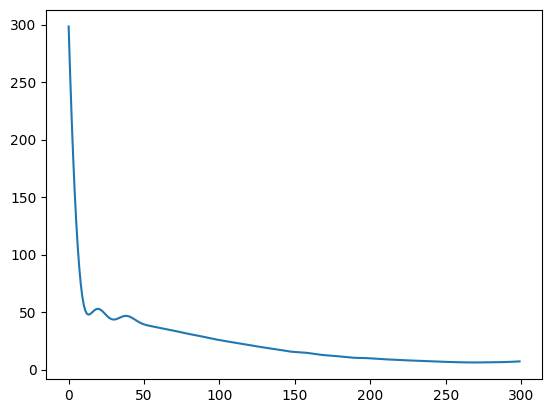

In [37]:
plt.plot(loss_dist_list,label='dist')
plt.show()

In [38]:
emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
pred_t = classifier(emb_t).to(device)
from sklearn.metrics import roc_auc_score
roc_auc_score(label_tgt.detach().cpu().numpy().flatten(),pred_t.detach().cpu().numpy().flatten())

0.8604561108777824

AUC从0.820提高到了0.86